In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imutils

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
#from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import tensorflow as tf
# import keras
#from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
#from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
import imutils
import itertools

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers

class Distiller(keras.Model):
    def __init__(self, student, teacher):
      """
      teacher: teacher model
      student: student model
      """
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student

    def compile(
      self,
      optimizer,
      metrics,
      student_loss_fn,
      distillation_loss_fn,
      alpha=0.1,
      temperature=3,
    ):
      """ Configure the distiller.

      Args:
          optimizer: Keras optimizer for the student weights
          metrics: Keras metrics for evaluation
          student_loss_fn: Loss function of difference between student
              predictions and ground-truth
          distillation_loss_fn: Loss function of difference between soft
              student predictions and soft teacher predictions
          alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
          temperature: Temperature for softening probability distributions.
              Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature

    def train_step(self, data):
      # Unpack data
      x, y = data

      # Forward pass of teacher
      teacher_predictions = self.teacher(x, training=False)

      with tf.GradientTape() as tape:
          # Forward pass of student
          student_predictions = self.student(x, training=True)

          # Compute losses
          student_loss = self.student_loss_fn(y, student_predictions)
          distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1), # soft label from teacher 
              tf.nn.softmax(student_predictions / self.temperature, axis=1), # soft prediction from student
          )
          loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Compute gradients
      trainable_vars = self.student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics configured in `compile()`.
      self.compiled_metrics.update_state(y, student_predictions)

      # Return a dict of performance
      results = {m.name: m.result() for m in self.metrics}
      results.update(
          {"student_loss": student_loss, "distillation_loss": distillation_loss}
      )
      return results

    def test_step(self, data):
      # Unpack the data
      x, y = data

      # Compute predictions
      y_prediction = self.student(x, training=False)

      # Calculate the loss
      student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics.
      self.compiled_metrics.update_state(y, y_prediction)

      # Return a dict of performance
      results = {m.name: m.result() for m in self.metrics}
      results.update({"student_loss": student_loss})
      return results


In [ ]:
CNN = Sequential()

#1
CNN.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)))
CNN.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2,2)))

#2
CNN.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))

#3
CNN.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))

#4
CNN.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))
CNN.add(Dropout(0.2))

#5
CNN.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
CNN.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size = (2,2)))
CNN.add(Dropout(0.2))

#Fully Connected
CNN.add(Flatten())
CNN.add(Dense(units = 512 , activation = 'tanh'))
CNN.add(Dropout(0.7))
CNN.add(Dense(units = 128 , activation = 'tanh'))
CNN.add(Dropout(0.5))
CNN.add(Dense(units = 64 , activation = 'tanh'))
CNN.add(Dropout(0.3))
CNN.add(Flatten())

CNN.add(Dense(units = 4 , activation = 'softmax'))

CNN.compile(optimizer = "adam" , 
               loss = 'sparse_categorical_crossentropy' , 
               metrics = ['accuracy'])
CNN.summary()

callback1 = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
callback2 = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
callback3 = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# historyCNN = CNN.fit(
#     train_images, 
#     train_labels, 
#     batch_size = 32, 
#     epochs = EPOCHS, 
    # validation_data=(test_images, test_labels), 
#     callbacks=[callback1, callback3])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 120, 120, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 120, 120, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 60, 60, 16)        0         
_________________________________________________________________
separable_conv2d_32 (Separab (None, 60, 60, 32)        688       
_________________________________________________________________
separable_conv2d_33 (Separab (None, 60, 60, 32)        1344      
_________________________________________________________________
batch_normalization_16 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 32)       

ValueError: ignored

In [ ]:
# Create the teacher
teacher = Sequential([CNN],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        CNN
    ],
    name="student",
)

# Clone student for later comparison
# student_scratch = keras.models.clone_model(student)

In [ ]:
def getImgContours(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [ ]:
def getBoxes(contours, orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [ ]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)

# Load Image Using Os


In [ ]:
IMAGE_SIZE = 120
EPOCHS = 20

In [ ]:

datasets = ['/content/drive/MyDrive/BME2/dataset2-master/images/TRAIN', '/content/drive/MyDrive/BME2/dataset2-master/images/TEST']
images = []
labels = []
  #lặp qua các folder trong thư mục datasets
count =0
for dataset in datasets:

    for folder in os.listdir(dataset):

        if folder in ['EOSINOPHIL']: label = 0
        elif folder in ['LYMPHOCYTE']: label = 1
        elif folder in ['MONOCYTE']: label = 2
        elif folder in ['NEUTROPHIL']: label = 3

        for file in tqdm(os.listdir(os.path.join(dataset, folder))):

            img_path = os.path.join(os.path.join(dataset, folder), file)

            # Open 
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
            
            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
            
            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
            
            #detecting the blood cell
            edgedImage = findEdges(image1)
            edgedContours = getImgContours(edgedImage)
            edgedBoxes =  getBoxes(edgedContours, image.copy())
            if len(edgedBoxes)==0:
                count +=1
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))
            
            # draw the contour and fill it 
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
            
            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0
            
            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                count +=1
                continue
            # resize th image
            image = cv2.resize(image, image_size)

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')

return images, labels


100%|██████████| 620/620 [00:04<00:00, 134.21it/s]


In [ ]:
print(len(images))
print(len(labels))

12130
12130


In [ ]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
# test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [ ]:
print(len(train_images))
print(len(train_labels))
# print(len(val_images))
# print(len(val_labels))
print(len(test_images))
print(len(test_labels))

9704
9704
1213
1213
1213
1213


In [ ]:

print("Training images: {}".format(train_images.shape))
print("Training labels: {}".format(train_labels.shape))
# print("Validation images: {}".format(val_images.shape))
# print("Validation labels: {}".format(val_labels.shape))
print("Test images: {}".format(test_images.shape))
print("Test labels: {}".format(test_labels.shape))

Training images: (9704, 120, 120)
Training labels: (9704,)
Validation images: (1213, 120, 120)
Validation labels: (1213,)
Test images: (1213, 120, 120)
Test labels: (1213,)


9704


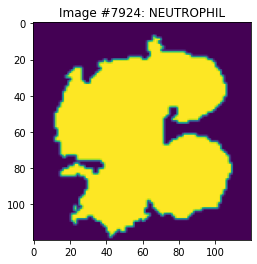

In [ ]:
#hiển thị train image  
print(len(train_images))
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.title('Image #{}: '.format(index) + class_names[train_labels[index]])
plt.show()
    

Text(0.5, 1.0, 'Ground Truth : 2')

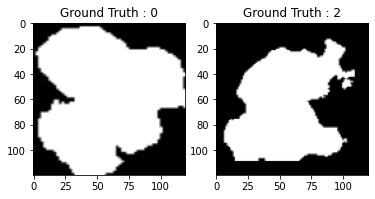

In [ ]:
# Ground truth
# Hiển thị ảnh từ train data
plt.subplot(121)
index = np.random.randint(train_images.shape[0])
plt.imshow(train_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[index]))

# Hiển thị ảnh từ test data
plt.subplot(122)
index = np.random.randint(test_images.shape[0])
plt.imshow(test_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[index]))



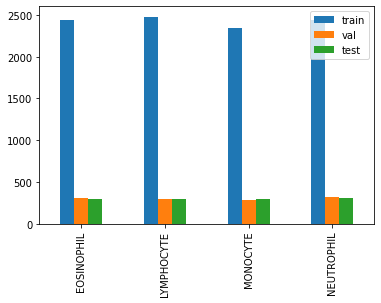

In [ ]:
_, train_counts = np.unique(train_labels, return_counts = True)
# _, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

# pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()
pd.DataFrame({'train': train_counts, "test": test_counts}, index = class_names).plot.bar()
plt.show()

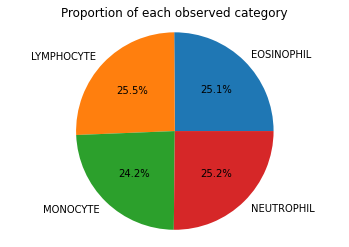

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
#Normalization
train_images = train_images / 255.0 
# val_images = val_images / 255.0
test_images = test_images / 255.0

9704


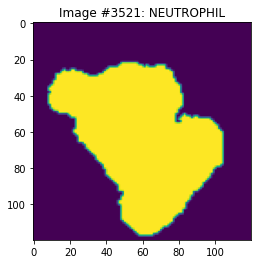

In [ ]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

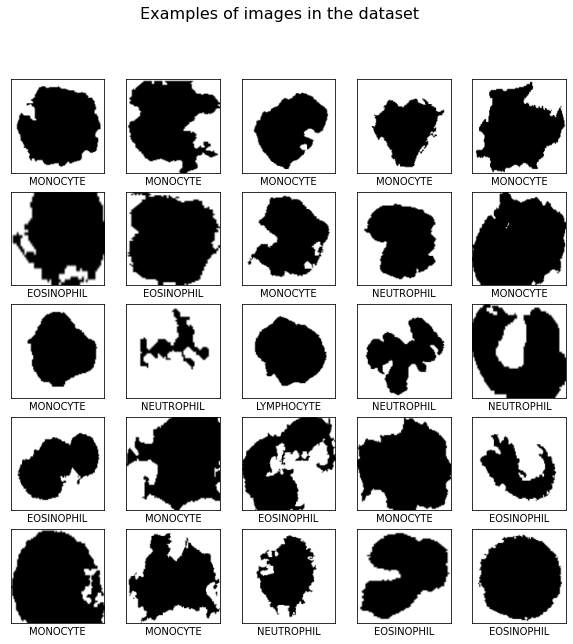

In [ ]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [ ]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

In [ ]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()


In [ ]:
plot_accuracy_loss_chart(historyCNN)

NameError: ignored

In [ ]:
results = CNN.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")


results = CNN.evaluate(val_images, val_labels)

print("Loss of validation model is ", results[0])
print("Accuracy of validation model is ", results[1]*100, "%")

results = CNN.evaluate(train_images, train_labels)

print("Loss of train model  is ", results[0])
print("Accuracy of train model is ", results[1]*100, "%")

In [ ]:
CNN.save('/content/drive/MyDrive/BME2/Bloodcell_Classification_CNN_Custom_Build_10_epochs.h5')

In [ ]:
gen = ImageDataGenerator()

In [ ]:
from sklearn.metrics import classification_report

predictions = CNN.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

In [ ]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Nhom 0)', 'LYMPHOCYTE (Nhom 1)', 'MONOCYTE (Nhom 2)', 'NEUTROPHIL (Nhom 3)']))

In [ ]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [ ]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())
specificity(test_labels,predictions)

In [ ]:
tn, fp, fn, tp = confusion_matrix(test_labels, predictions).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("Accuracy on testing data: {:.5f}%".format(100*accuracy))
print("Spectivity on testing data: {:.5f}%".format(100*specificity))
print("Sensitivy on testing data: {:.5f}%".format(100*sensitivity))